# KATO Hierarchical Training - Multi-Run Comparison Analysis

**Purpose**: Compare training runs with different configurations to find optimal hyperparameters.

## How It Works

1. **Training** (`training.ipynb`) captures **snapshots** of each run before MongoDB is cleared
2. **Analysis** (this notebook) loads snapshots to compare multiple runs side-by-side
3. **Optimization** finds the best configuration based on your goals

---

**This notebook provides**:
- ✅ **Multi-run comparison** - Compare 10+ training runs simultaneously
- ✅ **Saved snapshots** - Historical data preserved even after MongoDB clearing
- ✅ **Zipfian analysis** - Frequency distribution quality metrics (power-law fits)
- ✅ **Performance visualization** - Configuration parameters vs metrics
- ✅ **Scaling analysis** - How patterns/storage grow with sample count
- ✅ **Configuration optimizer** - Recommends best settings for your goals

**Key Insights**:
- Zipf alpha (α) ~1.0-1.5 indicates healthy Zipfian distribution
- Higher throughput (samples/sec) = faster training
- Pattern counts should decrease at higher levels (node0 > node1 > node2 > node3)
- Storage efficiency = patterns per MB

**Before using**: Complete at least 2-3 training runs using `training.ipynb` with different configurations.

## 1. Setup and Imports

In [1]:
# Import analysis and comparison tools
from tools import (
    # Core analysis
    TrainingHistory,
    TrainingRunSnapshot,
    
    # Comparison visualizations
    plot_configuration_table,
    plot_frequency_comparison,
    plot_hierarchy_utilization,
    plot_storage_breakdown,
    plot_performance_scatter,
    plot_scaling_analysis,
    plot_efficiency_metrics,
    plot_configuration_heatmap,
    find_optimal_configuration,
    print_comparison_summary
)

import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

print("✓ All modules imported successfully")
print("✓ Ready for multi-run comparison analysis")

None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


✓ All modules imported successfully
✓ Ready for multi-run comparison analysis


## 2. Load Training History

View all training runs recorded in the SQLite database.

In [2]:
# Load training history database
history = TrainingHistory(db_path='./training_history.db', verbose=True)

print(f"\n{'='*80}")
print("TRAINING HISTORY SUMMARY")
print(f"{'='*80}\n")

history.print_summary()

# Get recent runs
recent_runs = history.get_recent_runs(n=100)

if recent_runs:
    print(f"\n📊 RECENT TRAINING RUNS:\n")
    for run in recent_runs:
        # Calculate rate from actual data
        rate = run.samples_processed / run.actual_time_seconds if run.actual_time_seconds > 0 else 0
        
        print(f"Run ID: {run.run_id}")
        print(f"  Dataset: {run.dataset_key}")
        print(f"  Samples: {run.samples_processed:,}")
        print(f"  Time: {run.actual_time_seconds:.2f}s")
        print(f"  Rate: {rate:.2f} samples/sec")
        print()
else:
    print("\n⚠️  No training runs found in history.")
    print("   Run training.ipynb first to create training data.")

✓ TrainingHistory initialized (29 runs in database)

TRAINING HISTORY SUMMARY


TRAINING HISTORY SUMMARY

📊 DATABASE STATISTICS
  Total runs: 29
  Date range: 2025-10-21 → 2025-10-22

🎯 ESTIMATION ACCURACY
  Time error: 0.0% (trend: insufficient_data)
  Storage error: 0.0% (trend: insufficient_data)

🏆 RECENT RUNS

  run_c5x5_w6_s10000 (2025-10-22 17:56)
    Config: 5 levels, chunk_size=5
    Time: 3677.3s (no estimate)
    Storage: 8.31GB (no estimate)

  run_c7x5_w6_s10000 (2025-10-22 16:03)
    Config: 5 levels, chunk_size=7
    Time: 2686.3s (no estimate)
    Storage: 5.56GB (no estimate)

  run_c5-4-4-3-3_w6_s10000 (2025-10-22 15:15)
    Config: 5 levels, chunk_size=5
    Time: 3897.5s (no estimate)
    Storage: 9.20GB (no estimate)

  run_c8x5_w6_s10000 (2025-10-22 13:46)
    Config: 5 levels, chunk_size=8
    Time: 2428.2s (no estimate)
    Storage: 4.88GB (no estimate)

  run_c6x5_w6_s10000 (2025-10-22 13:00)
    Config: 5 levels, chunk_size=6
    Time: 3372.2s (no estimate)
  

## 3. Load Multiple Runs for Comparison

Select training runs to compare. You can either:
- Load N most recent runs
- Specify run IDs manually

In [3]:
# Select how many recent runs to compare (or specify run_ids manually)
NUM_RUNS_TO_COMPARE = 10  # Adjust as needed

# Option 1: Get N most recent runs
comparison_df = history.compare_runs(n_recent=NUM_RUNS_TO_COMPARE)

# Option 2: Compare specific runs (uncomment and modify)
# run_ids = ['run_1761067341_4534', 'run_1761067086_3674']
# comparison_df = history.compare_runs(run_ids=run_ids)

if not comparison_df.empty:
    print(f"\n{'='*80}")
    print(f"LOADED {len(comparison_df)} TRAINING RUNS FOR COMPARISON")
    print(f"{'='*80}\n")
    
    # Show basic info
    print(comparison_df[['Run ID', 'Dataset', 'Samples', 'Chunk Size', 'Time (s)', 'Rate (samples/s)']].to_string(index=False))
    
    print(f"\n✓ Ready for comparison analysis")
else:
    print("\n⚠️  No training runs found. Run training.ipynb first.")


LOADED 10 TRAINING RUNS FOR COMPARISON

              Run ID  Dataset  Samples Chunk Size  Time (s)  Rate (samples/s)
  run_c5x5_w6_s10000 wikitext    10000          5   3677.34              2.72
  run_c7x5_w6_s10000 wikitext    10000          7   2686.31              3.72
run_c5-4-4-3-3_w6_s1 wikitext    10000  5,4,4,3,3   3897.51              2.57
  run_c8x5_w6_s10000 wikitext    10000          8   2428.16              4.12
  run_c6x5_w6_s10000 wikitext    10000          6   3372.19              2.97
  run_c3x5_w6_s10000 wikitext    10000          3   7388.12              1.35
run_c8x5_w6_s1000_17 wikitext     1000          8    197.93              5.05
run_c6x5_w6_s1000_17 wikitext     1000          6    234.91              4.26
run_c3x5_w6_s1000_17 wikitext     1000          3    616.11              1.62
run_c3-5-5-8-3_w6_s1 wikitext     1000  3,5,5,8,3    524.74              1.91

✓ Ready for comparison analysis


## 3.1. Understanding Chunk Size Configurations

**Chunk sizes** can be **uniform** (all nodes use same size) or **non-uniform** (different sizes per node).

### Chunk Size Patterns

| Pattern | Example | Description |
|---------|---------|-------------|
| **uniform** | `[8, 8, 8, 8]` | All nodes use same chunk size (default) |
| **increasing** | `[4, 5, 10, 15]` | Each level uses larger chunks (experimental) |
| **decreasing** | `[15, 10, 5, 4]` | Each level uses smaller chunks (experimental) |
| **mixed** | `[8, 5, 12, 7]` | Arbitrary pattern (rare) |

### New Comparison Columns

The comparison table now includes:
- **Chunk Pattern**: Pattern type (uniform/increasing/decreasing/mixed)
- **Chunk Min**: Smallest chunk size across nodes
- **Chunk Max**: Largest chunk size across nodes
- **Chunk Mean**: Average chunk size (used for numeric comparisons)
- **Chunk Uniform**: Boolean flag (True = all nodes same size)

### Filtering and Interpretation

**To filter for uniform configs only**:
```python
uniform_only_df = comparison_df[comparison_df['Chunk Uniform'] == True]
```

**To filter for non-uniform configs**:
```python
non_uniform_df = comparison_df[comparison_df['Chunk Uniform'] == False]
```

**To group by pattern type**:
```python
grouped = comparison_df.groupby('Chunk Pattern')
for pattern, group_df in grouped:
    print(f"\n{pattern.upper()} configurations:")
    print(group_df[['Run ID', 'Chunk Size', 'Rate (samples/s)', 'Total Patterns']])
```

### Recommendations

**For most experiments**: Use **uniform** chunk sizes (e.g., `[8, 8, 8, 8]`)
- Easier to interpret results
- Consistent scaling behavior across hierarchy
- Default preference in optimizer

**For advanced experiments**: Try **increasing** patterns (e.g., `[4, 8, 16, 32]`)
- May capture different granularities
- Experimental - effects on Zipfian distribution unclear

⚠️ **Note**: Non-uniform configs are automatically handled:
- Scatter plots use `Chunk Mean` for X-axis when detected
- Scaling analysis warns if grouping by `Chunk Size` with mixed patterns
- Optimizer gives slight preference to uniform configs in tie-breakers

## 4. Configuration Comparison Table

Sortable, styled table showing all training runs with configuration parameters and results.

**Best values highlighted in green.**

In [4]:
if not comparison_df.empty:
    print(f"\n{'='*80}")
    print("CONFIGURATION COMPARISON TABLE")
    print(f"{'='*80}\n")
    
    # Display styled table (best values highlighted)
    styled_table = plot_configuration_table(comparison_df, highlight_best=True)
    display(styled_table)
    
    # Print statistical summary
    print_comparison_summary(comparison_df)
else:
    print("\n⚠️  No comparison data available")


CONFIGURATION COMPARISON TABLE



,Run ID,Timestamp,Dataset,Samples,Chunk Size,Chunk Pattern,Chunk Min,Chunk Max,Chunk Mean,Chunk Uniform,Levels,Batch Size,Workers,Time (s),Rate (samples/s),Storage (MB),Total Patterns,Zipf Alpha,Hardware,Peak Mem (MB),Avg CPU (%)
0,run_c5x5_w6_s10000,2025-10-22 17:56,wikitext,10000,5,uniform,5,5,5.0,True,5,100,6,3677.340000,2.720000,98.740000,241294,0.063000,unknown,1233.900000,12.400000
1,run_c7x5_w6_s10000,2025-10-22 16:03,wikitext,10000,7,uniform,7,7,7.0,True,5,100,6,2686.310000,3.720000,75.740000,167596,0.029000,unknown,1226.200000,12.400000
2,run_c5-4-4-3-3_w6_s1,2025-10-22 15:15,wikitext,10000,"5,4,4,3,3",decreasing,3,5,3.8,False,5,100,6,3897.510000,2.570000,103.310000,255660,0.063000,unknown,1253.300000,12.000000
3,run_c8x5_w6_s10000,2025-10-22 13:46,wikitext,10000,8,uniform,8,8,8.0,True,5,100,6,2428.160000,4.120000,69.200000,146502,0.025000,unknown,1230.100000,12.500000
4,run_c6x5_w6_s10000,2025-10-22 13:00,wikitext,10000,6,uniform,6,6,6.0,True,5,100,6,3372.190000,2.970000,84.900000,197085,0.039000,unknown,1219.200000,12.400000
5,run_c3x5_w6_s10000,2025-10-22 03:29,wikitext,10000,3,uniform,3,3,3.0,True,5,100,6,7388.120000,1.350000,151.500000,410642,0.255000,unknown,1232.900000,11.600000
6,run_c8x5_w6_s1000_17,2025-10-22 01:25,wikitext,1000,8,uniform,8,8,8.0,True,5,100,6,197.930000,5.050000,7.870000,15095,0.012000,unknown,1203.500000,16.800000
7,run_c6x5_w6_s1000_17,2025-10-22 01:19,wikitext,1000,6,uniform,6,6,6.0,True,5,100,6,234.910000,4.260000,9.590000,20511,0.023000,unknown,1205.300000,17.300000
8,run_c3x5_w6_s1000_17,2025-10-22 00:50,wikitext,1000,3,uniform,3,3,3.0,True,5,100,6,616.110000,1.620000,17.520000,45695,0.167000,unknown,1227.900000,16.900000
9,run_c3-5-5-8-3_w6_s1,2025-10-22 00:39,wikitext,1000,"3,5,5,8,3",mixed,3,8,4.8,False,5,100,6,524.740000,1.910000,15.070000,38002,0.166000,unknown,1205.100000,16.900000



TRAINING RUN COMPARISON SUMMARY

Total runs compared: 10

          Metric       Min        Max        Mean           Std
         Samples  1000.000  10000.000   6400.0000   4647.580015
        Time (s)   197.930   7388.120   2502.3320   2258.668900
Rate (samples/s)     1.350      5.050      3.0290      1.230794
    Storage (MB)     7.870    151.500     63.3440     49.070616
  Total Patterns 15095.000 410642.000 153808.2000 128329.677847
      Zipf Alpha     0.012      0.255      0.0842      0.082443




## 5. Performance Visualizations

Scatter plots and charts showing how configuration parameters affect performance metrics.


📊 Chunk Size vs Throughput
⚠️  Non-uniform chunk sizes detected. Using 'Chunk Mean' for X-axis.


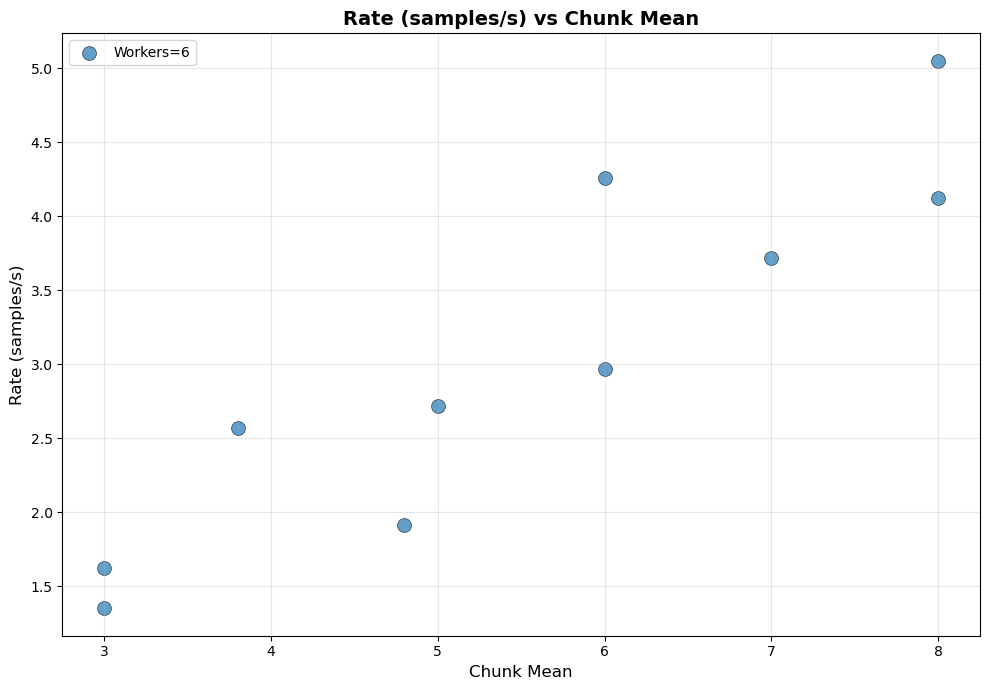


📊 Workers vs Throughput


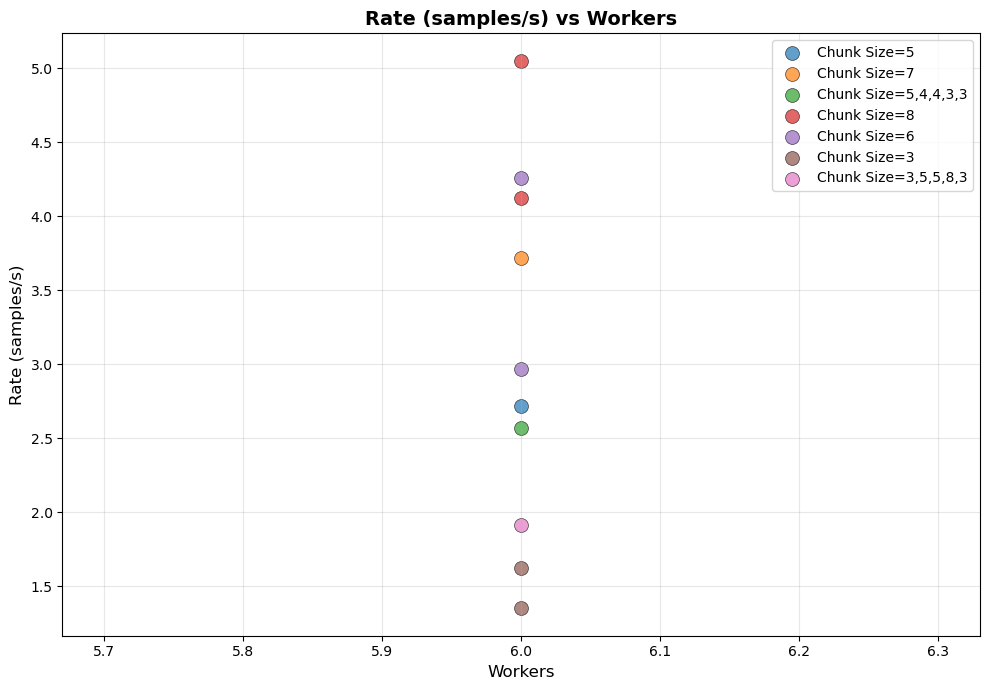


📊 Efficiency Metrics


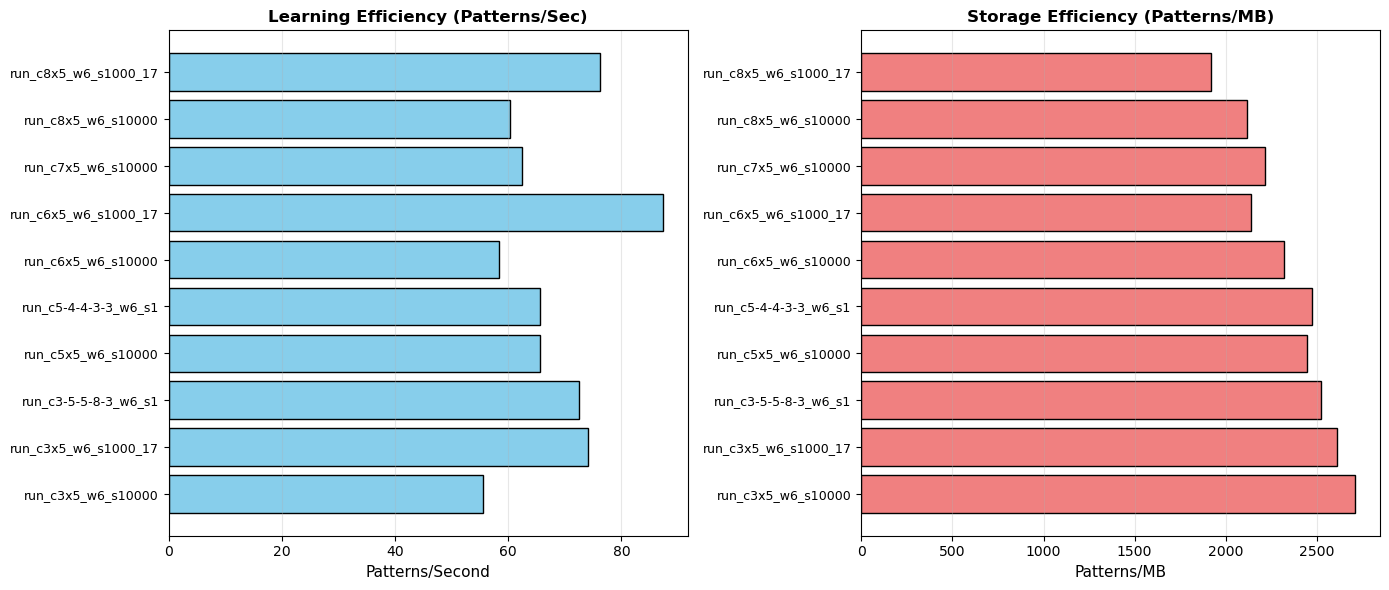


📊 Configuration Heatmap


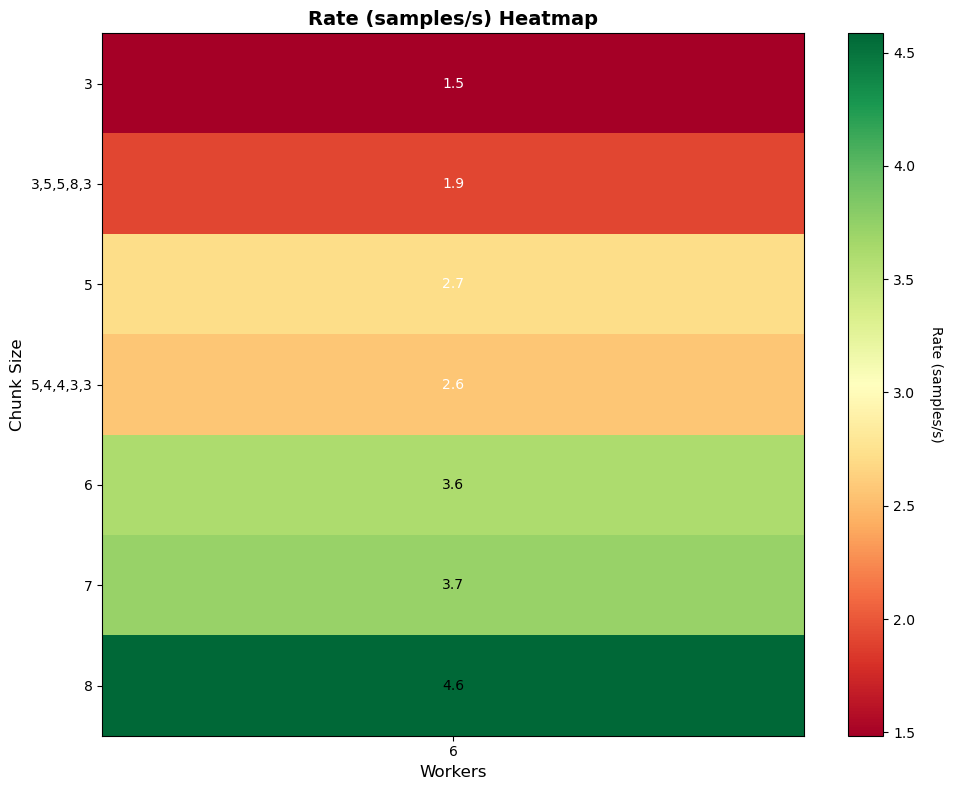

In [5]:
if not comparison_df.empty and len(comparison_df) >= 2:
    # Scatter: Chunk Size vs Throughput
    print("\n📊 Chunk Size vs Throughput")
    plot_performance_scatter(
        comparison_df,
        x_col='Chunk Size',
        y_col='Rate (samples/s)',
        color_by='Workers'
    )
    
    # Scatter: Workers vs Throughput
    print("\n📊 Workers vs Throughput")
    plot_performance_scatter(
        comparison_df,
        x_col='Workers',
        y_col='Rate (samples/s)',
        color_by='Chunk Size'
    )
    
    # Efficiency metrics
    print("\n📊 Efficiency Metrics")
    plot_efficiency_metrics(comparison_df)
    
    # Heatmap (if enough data points)
    if len(comparison_df) >= 4:
        print("\n📊 Configuration Heatmap")
        try:
            plot_configuration_heatmap(
                comparison_df,
                row_param='Chunk Size',
                col_param='Workers',
                value_metric='Rate (samples/s)'
            )
        except Exception as e:
            print(f"⚠️  Cannot create heatmap: {e}")
else:
    print("\n⚠️  Need at least 2 runs for performance visualization")

## 6. Pattern Quality Comparison

Compare learned pattern quality across runs using frequency distributions and Zipfian analysis.

**Zipf alpha (α)**: Power-law exponent. Ideal range: 1.0-1.5 for natural language.


📊 Frequency Distribution Comparison (Zipfian Analysis)
   Comparing node0 patterns across 10 runs...


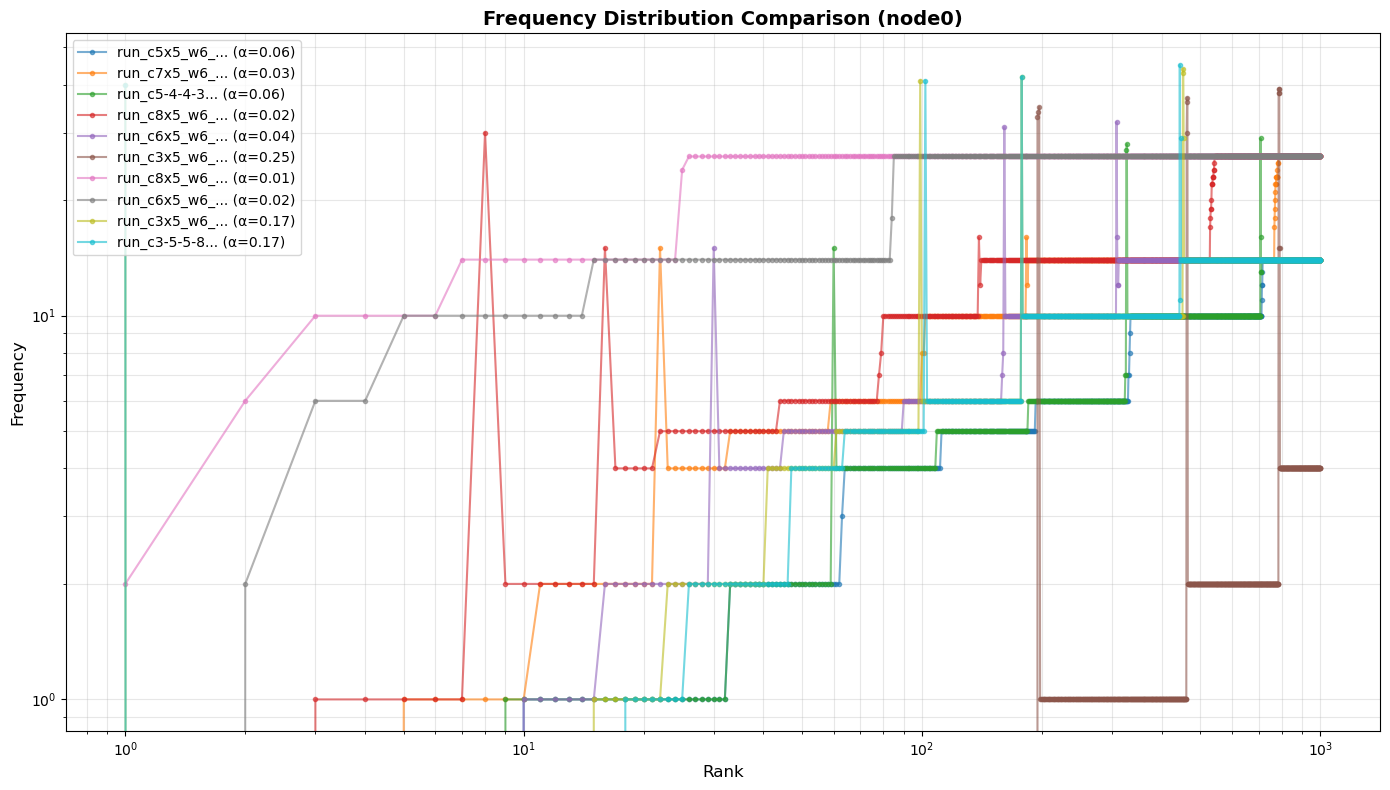


📊 Hierarchy Utilization (Patterns per Node)


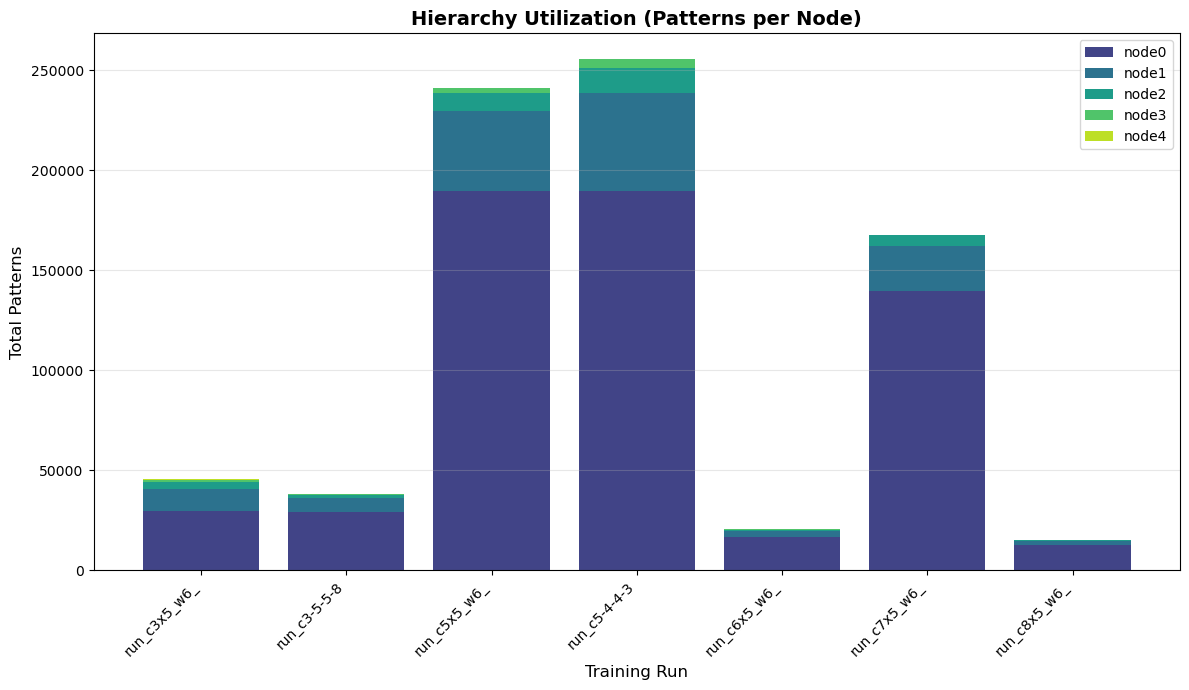


📊 Storage Breakdown (MB per Node)


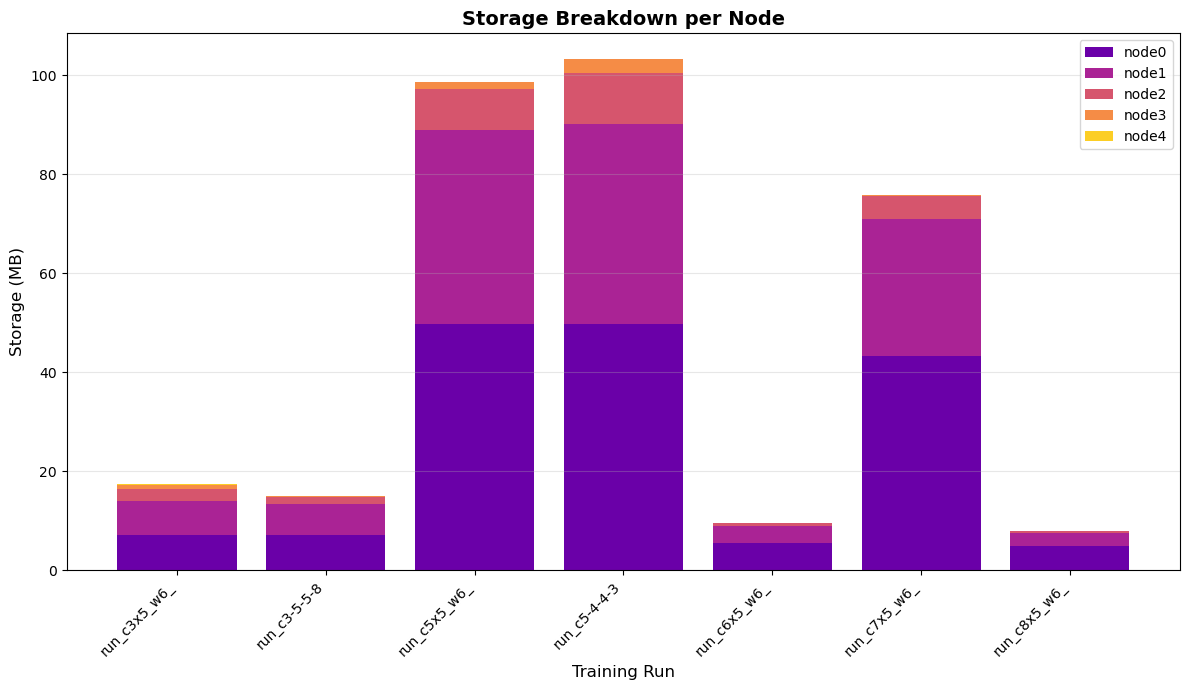

In [6]:
if not comparison_df.empty and len(comparison_df) >= 2:
    # Configuration: How many runs to show in pattern quality charts
    # Set to None to show all runs, or a specific number to limit display
    MAX_PATTERN_CHARTS = 10  # Change this to 5 if charts become too cluttered
    
    # Get run IDs for comparison
    n_runs = MAX_PATTERN_CHARTS if MAX_PATTERN_CHARTS else len(comparison_df)
    run_ids_to_compare = comparison_df['Run ID'].head(n_runs).tolist()
    # Remove truncation suffix if present
    run_ids_to_compare = [rid.replace('...', '') if '...' in rid else rid for rid in run_ids_to_compare]
    
    # Get full run IDs from history
    all_runs = history.get_all_runs()
    full_run_ids = [run.run_id for run in all_runs if run.run_id[:20] in [rid[:20] for rid in run_ids_to_compare]]
    
    if full_run_ids:
        # Frequency distribution overlay (Zipfian curves)
        print(f"\n📊 Frequency Distribution Comparison (Zipfian Analysis)")
        print(f"   Comparing node0 patterns across {len(full_run_ids[:n_runs])} runs...")
        plot_frequency_comparison(history, full_run_ids[:n_runs])
        
        # Hierarchy utilization
        print(f"\n📊 Hierarchy Utilization (Patterns per Node)")
        plot_hierarchy_utilization(history, full_run_ids[:n_runs])
        
        # Storage breakdown
        print(f"\n📊 Storage Breakdown (MB per Node)")
        plot_storage_breakdown(history, full_run_ids[:n_runs])
    else:
        print("\n⚠️  No snapshots available for comparison")
        print("   Make sure training runs have captured snapshots")
else:
    print("\n⚠️  Need at least 2 runs with snapshots for pattern quality comparison")

## 6.1 Hierarchical Alpha Analysis

Analyze how Zipfian alpha (α) changes across hierarchy levels.

**Key Question**: Does compression improve or degrade at higher abstraction levels?

**Ideal scenario**: 
- node0 (chunks): α ~ 0.5-1.0 (basic phrase patterns)
- node1 (paragraphs): α ~ 1.0-1.5 (reusable paragraph structures)
- node2 (chapters): α ~ 1.0-1.5 (common chapter patterns)
- **Higher levels should have HIGHER alpha** (more reuse)

**What we're testing**:
- If α increases with level → Good hierarchical compression ✅
- If α decreases with level → Documents are structurally unique ⚠️
- If α is None → Insufficient data (need more training) ❌

**Interpretation**:
- **α < 0.1**: Poor pattern reuse (mostly unique patterns)
- **α = 0.1-0.5**: Weak Zipfian distribution (some reuse)
- **α = 1.0-1.5**: Healthy Zipfian (ideal range for natural language)
- **α > 2.0**: Extreme concentration (very few dominant patterns)


ZIPFIAN ALPHA ACROSS HIERARCHY LEVELS

                 Run ID  node0  node1 node2 node3 node4
     run_c5x5_w6_s10000 0.0630 0.0103   N/A   N/A   N/A
     run_c7x5_w6_s10000 0.0290 0.0033   N/A   N/A   N/A
run_c5-4-4-3-3_w6_s1... 0.0628 0.0085   N/A   N/A   N/A
     run_c8x5_w6_s10000 0.0246 0.0027   N/A   N/A   N/A
     run_c6x5_w6_s10000 0.0388 0.0059   N/A   N/A   N/A

💡 Key Observations:
   • Compare alpha values across nodes for each run
   • Ideally: alpha should INCREASE at higher levels (more reuse)
   • 'N/A' means < 3 unique frequency values (insufficient data)
   • Target range: α = 1.0-1.5 (natural language)


📊 Alpha Across Hierarchy Levels
   Visualizing how alpha changes from node0 → node4



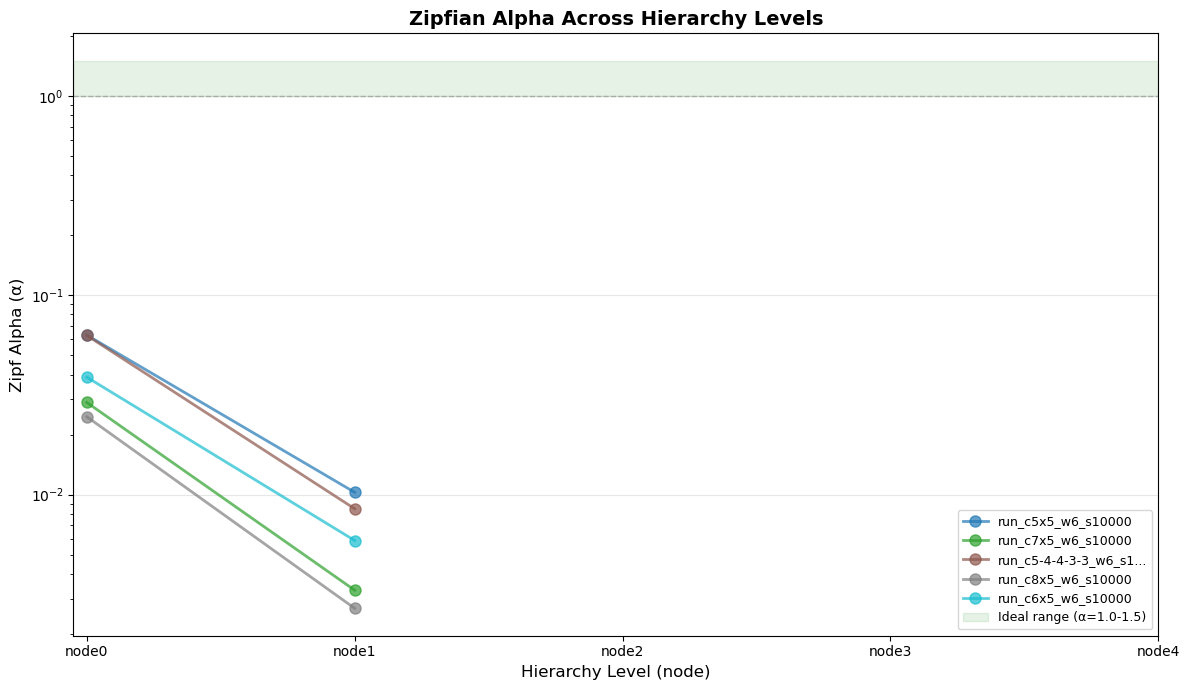


💡 Analysis:
   • If lines go UP → hierarchical compression is working ✅
   • If lines go DOWN → documents are structurally unique ⚠️
   • If lines are flat → consistent reuse pattern across levels
   • Missing points → alpha could not be computed (N/A above)


📊 Pattern Count vs Alpha
   Testing if low alpha is due to insufficient pattern counts



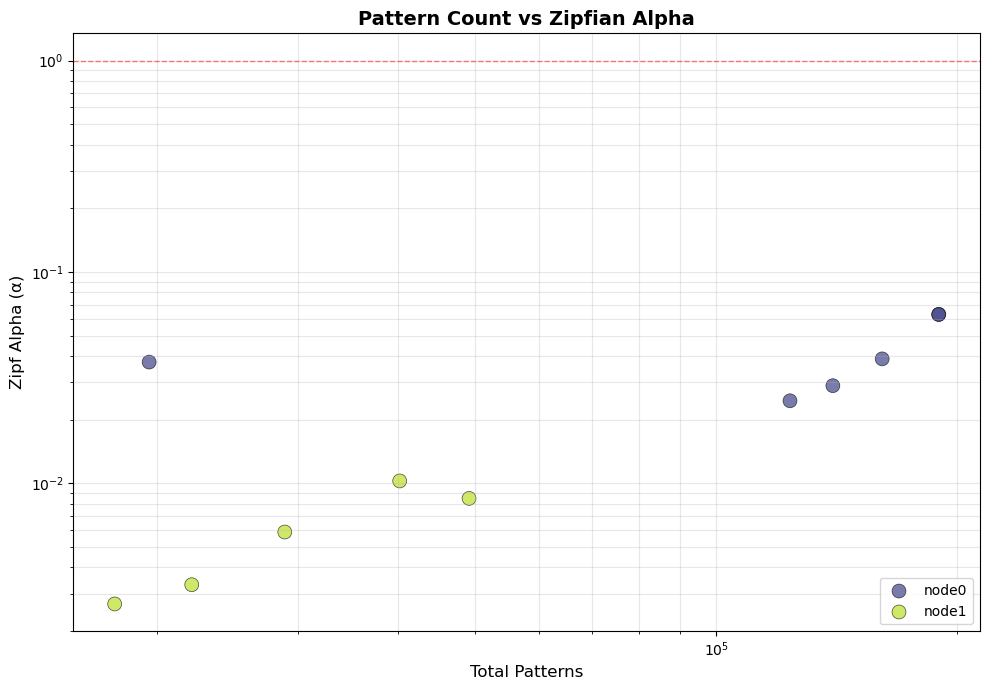


💡 Insight:
   • If node0 has many patterns but low alpha → genuinely poor reuse
   • If higher nodes have few patterns AND no alpha → need more training
   • Ideally: see alpha values closer to 1.0 horizontal line


In [7]:
# Import the new hierarchical alpha visualization functions
from tools import plot_hierarchy_alpha_comparison, plot_alpha_vs_patterns_scatter

if not comparison_df.empty and len(comparison_df) >= 2:
    # Configuration: How many runs to show
    MAX_ALPHA_CHARTS = 5  # Limit to avoid clutter (can increase if needed)
    
    # Get run IDs for comparison
    n_runs = min(MAX_ALPHA_CHARTS, len(comparison_df))
    run_ids_to_compare = comparison_df['Run ID'].head(n_runs).tolist()
    # Remove truncation suffix if present
    run_ids_to_compare = [rid.replace('...', '') if '...' in rid else rid for rid in run_ids_to_compare]
    
    # Get full run IDs from history
    all_runs = history.get_all_runs()
    full_run_ids = [run.run_id for run in all_runs if run.run_id[:20] in [rid[:20] for rid in run_ids_to_compare]]
    
    if full_run_ids:
        # Print summary table of alpha values per node
        print(f"\n{'='*80}")
        print(f"ZIPFIAN ALPHA ACROSS HIERARCHY LEVELS")
        print(f"{'='*80}\n")
        
        # Create summary table
        alpha_data = []
        for run_id in full_run_ids[:n_runs]:
            snapshot = history.load_snapshot(run_id)
            if snapshot:
                row = {'Run ID': run_id if len(run_id) <= 20 else run_id[:20] + '...'}
                for node_name in sorted(snapshot.nodes.keys()):
                    node = snapshot.nodes[node_name]
                    alpha_val = node.zipf_alpha if node.zipf_alpha is not None else 'None'
                    if alpha_val != 'None':
                        row[node_name] = f"{alpha_val:.4f}"
                    else:
                        row[node_name] = 'N/A'
                alpha_data.append(row)
        
        if alpha_data:
            alpha_df = pd.DataFrame(alpha_data)
            print(alpha_df.to_string(index=False))
            
            print(f"\n💡 Key Observations:")
            print("   • Compare alpha values across nodes for each run")
            print("   • Ideally: alpha should INCREASE at higher levels (more reuse)")
            print("   • 'N/A' means < 3 unique frequency values (insufficient data)")
            print("   • Target range: α = 1.0-1.5 (natural language)\n")
        
        # Plot 1: Hierarchy Alpha Comparison
        print("\n📊 Alpha Across Hierarchy Levels")
        print("   Visualizing how alpha changes from node0 → node4\n")
        plot_hierarchy_alpha_comparison(history, full_run_ids[:n_runs])
        
        print("\n💡 Analysis:")
        print("   • If lines go UP → hierarchical compression is working ✅")
        print("   • If lines go DOWN → documents are structurally unique ⚠️")
        print("   • If lines are flat → consistent reuse pattern across levels")
        print("   • Missing points → alpha could not be computed (N/A above)\n")
        
        # Plot 2: Alpha vs Pattern Count Scatter
        print("\n📊 Pattern Count vs Alpha")
        print("   Testing if low alpha is due to insufficient pattern counts\n")
        plot_alpha_vs_patterns_scatter(history, full_run_ids)
        
        print("\n💡 Insight:")
        print("   • If node0 has many patterns but low alpha → genuinely poor reuse")
        print("   • If higher nodes have few patterns AND no alpha → need more training")
        print("   • Ideally: see alpha values closer to 1.0 horizontal line")
        
    else:
        print("\n⚠️  No snapshots available for hierarchical alpha analysis")
else:
    print("\n⚠️  Need at least 2 runs with snapshots for hierarchical alpha analysis")

## 7. Scaling Analysis

Analyze how patterns and storage grow with sample count for different configurations.

**Good indicators**:
- Sublinear pattern growth (pattern reuse)
- Linear storage growth (predictable)
- Smaller chunk sizes may show more compression


📊 Scaling Analysis
   How do patterns and storage grow with sample count?

⚠️  Non-uniform chunk sizes detected. Consider grouping by 'Chunk Pattern' instead.
   Grouping by 'Chunk Size' will separate configs like [4,5,10] and [4,5,15].


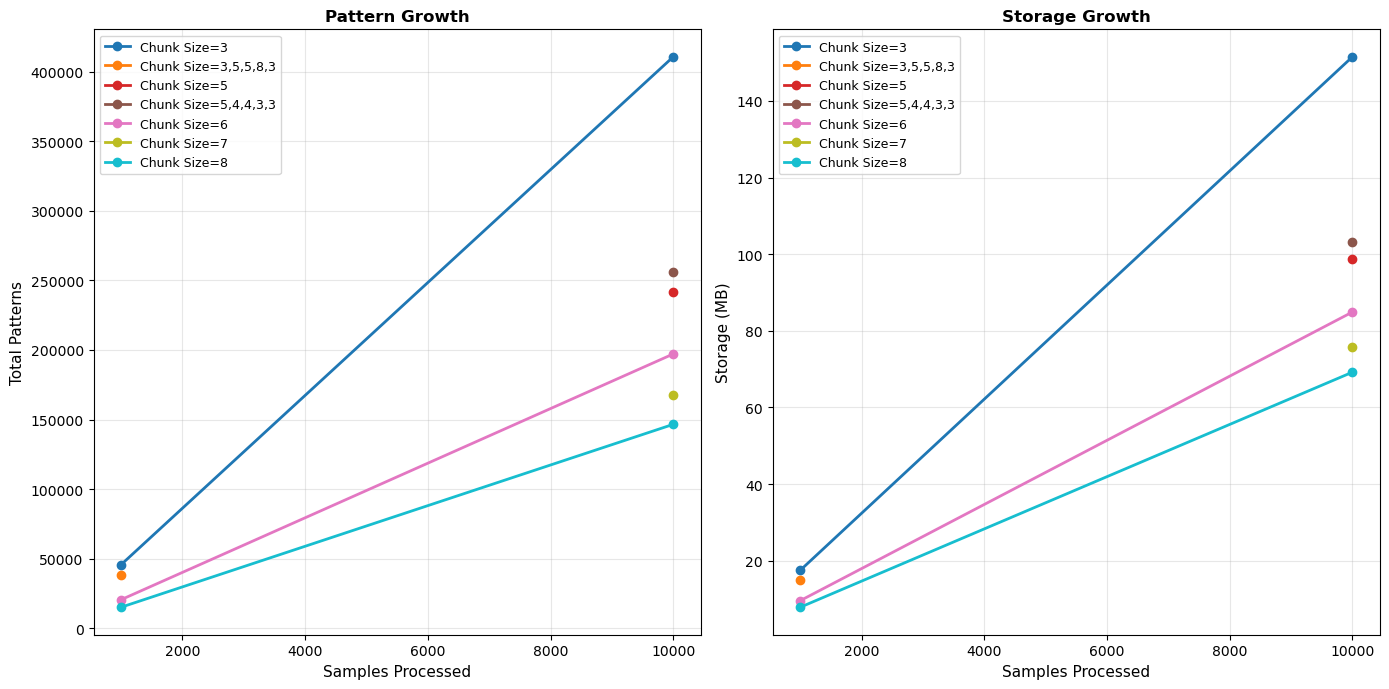


💡 Insights:
   - Look for sublinear growth in patterns (good compression)
   - Linear storage growth is expected
   - Compare curves across different chunk sizes


In [8]:
if not comparison_df.empty and len(comparison_df) >= 3:
    print("\n📊 Scaling Analysis")
    print("   How do patterns and storage grow with sample count?\n")
    
    # Group by chunk size and plot scaling curves
    plot_scaling_analysis(comparison_df, group_by='Chunk Size')
    
    print("\n💡 Insights:")
    print("   - Look for sublinear growth in patterns (good compression)")
    print("   - Linear storage growth is expected")
    print("   - Compare curves across different chunk sizes")
else:
    print("\n⚠️  Need at least 3 runs for scaling analysis")
    print("   Train multiple runs with varying sample counts")

## 8. Optimal Configuration Finder

Find the best configuration based on your optimization goal.

**Goals**:
- **Throughput**: Maximize training speed (samples/sec)
- **Quality**: Best Zipfian distribution (α closest to ideal range)
- **Storage**: Minimize disk usage (patterns per MB)
- **Balanced**: Combination of throughput + quality

In [9]:
if not comparison_df.empty:
    print(f"\n{'='*80}")
    print("OPTIMAL CONFIGURATION FINDER")
    print(f"{'='*80}\n")
    
    # Find optimal configs for different goals
    goals = ['throughput', 'quality', 'storage', 'balanced']
    
    for goal in goals:
        print(f"\n🎯 OPTIMIZING FOR: {goal.upper()}")
        print(f"{'-'*60}")
        
        optimal = find_optimal_configuration(history, goal=goal, min_samples=50)
        
        if 'error' in optimal:
            print(f"   ⚠️  {optimal['error']}")
        else:
            print(f"   Run ID: {optimal['run_id']}")
            print(f"   Configuration:")
            print(f"      Chunk Size: {optimal['chunk_size']}")
            print(f"      Levels: {optimal['levels']}")
            print(f"      Batch Size: {optimal['batch_size']}")
            print(f"      Workers: {optimal['workers']}")
            print(f"   Performance:")
            print(f"      Rate: {optimal['rate']:.2f} samples/sec")
            print(f"      Patterns: {optimal['patterns']:,}")
            print(f"      Storage: {optimal['storage_mb']:.2f} MB")
            if optimal['zipf_alpha']:
                print(f"      Zipf α: {optimal['zipf_alpha']:.3f}")
    
    print(f"\n{'='*80}")
    print("💡 RECOMMENDATIONS")
    print(f"{'='*80}")
    print("\n  Use these results to guide your next training runs:")
    print("  - Throughput: Maximize training speed")
    print("  - Quality: Best Zipfian distribution (α ~ 1.0-1.5)")
    print("  - Storage: Minimize disk usage")
    print("  - Balanced: Best overall performance\n")
    
else:
    print("\n⚠️  No runs available for optimization")


OPTIMAL CONFIGURATION FINDER


🎯 OPTIMIZING FOR: THROUGHPUT
------------------------------------------------------------
   Run ID: run_c8x5_w6_s1000_17
   Configuration:
      Chunk Size: 8
      Levels: 5
      Batch Size: 100
      Workers: 6
   Performance:
      Rate: 5.05 samples/sec
      Patterns: 15,095
      Storage: 7.87 MB
      Zipf α: 0.012

🎯 OPTIMIZING FOR: QUALITY
------------------------------------------------------------
   Run ID: run_c3x5_w6_s10000
   Configuration:
      Chunk Size: 3
      Levels: 5
      Batch Size: 100
      Workers: 6
   Performance:
      Rate: 1.35 samples/sec
      Patterns: 410,642
      Storage: 151.50 MB
      Zipf α: 0.255

🎯 OPTIMIZING FOR: STORAGE
------------------------------------------------------------
   Run ID: run_c3x5_w6_s10000
   Configuration:
      Chunk Size: 3
      Levels: 5
      Batch Size: 100
      Workers: 6
   Performance:
      Rate: 1.35 samples/sec
      Patterns: 410,642
      Storage: 151.50 MB
      Zipf α

## Summary

### What This Analysis Tells You

**1. Pattern Quality Indicators**:
- ✅ **Zipfian distribution**: α ~1.0-1.5 indicates healthy power-law patterns
- ✅ **Pattern hierarchy**: node0 > node1 > node2 > node3 counts → proper abstraction
- ✅ **Frequency curves**: Log-log plots should be approximately linear

**2. Configuration Optimization**:
- Compare chunk sizes: smaller = more compression, larger = faster
- Worker count: sweet spot depends on CPU cores and I/O
- Batch size: larger = faster node0, diminishing returns above ~50

**3. Performance Trade-offs**:
- Throughput vs Quality: Sometimes inversely correlated
- Storage vs Patterns: More patterns = more storage (check efficiency)
- Speed vs Compression: Faster training may produce less compressed patterns

### Next Steps

**To improve results**:
1. Use the **Optimal Configuration Finder** (Section 8) to identify best settings
2. Train new runs with those configurations on larger datasets
3. Compare Zipf alpha values - aim for 1.0-1.5 range
4. Monitor scaling curves for sublinear pattern growth

**For production training**:
- Scale up to 10K+ samples using optimal configuration
- Use larger datasets (C4, RefinedWeb)
- Monitor storage growth and plan disk capacity

**For text generation** (future):
- Sample from high-frequency patterns at top level
- Unravel hierarchically (top-down recursion)
- Decode tokens to generate coherent text

### Documentation
- **training.ipynb**: Train models with automatic snapshot capture
- **PROJECT_OVERVIEW.md**: Hierarchical learning concepts
- **CLAUDE.md**: Project-specific instructions